# Analyzing Correlation Structures in a Model of Neural Activity-Dependent Homeostatic Plasticity (ADHP)

In [1]:
%pip install -q tellurium
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly
go = plotly.graph_objs
import ipywidgets as widgets
from IPython.display import display
from sklearn.linear_model import LinearRegression

Note: you may need to restart the kernel to use updated packages.


**Step 1**: Recreate individual timeseries from Figure 1

In [2]:
ADHPmodel = '''
R1: -> Vm ; (g1*(E1-Vm) + g2*(E2-Vm) + g3*(E3-Vm)) / Cm
R2: -> Ca ; (A*(e^(b*Vm)) - Ca) / TauCa
R3: -> g1 ; g1*(Ca - Ct) / Tau1
R4: -> g2 ; g2*(Ca - Ct) / Tau2
R5: -> g3 ; g3*(Ca - Ct) / Tau3

e = 2.7182818284                            #Euler's number

g1 = 100; g2 = 20; g3 = 10;            # conductances uS/nF
E1 = -90; E2 = -30; E3 = 50;           # corresponding reversal potentials
A = 109.2                              # uM (from experimental fitting)
b = .08                                # mV^-1 (from experiment fitting)
Ca = 0.2;                              # calcium concentration
Vm = -50;                              # membrane potential
Ct = 1;                                # (uM) target 
Cm = 1;                                # Membrane capacitance
Tau1 = 4000;
Tau2 = -6000;
Tau3 = -1000;
TauCa = 100;                           #ms
'''

r = te.loada(ADHPmodel)

In [3]:
Tauoptions = widgets.ToggleButtons(
    options=['Original', 'Flipped', 'Scaled','Custom'],
    description='Tau set:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Tau1 = 4000,Tau2 = -6000,Tau3 = -1000', 'Tau1 = 4000,Tau2 = 6000,Tau3 = -1000', 'Tau1 = 4000,Tau2 = -6000/10,Tau3 = -1000/40'],
)
Vmbox = widgets.Checkbox(
    value=False,
    description='Plot Mem. Voltage',
    disabled=False,
    indent=False,
    continuous_update=True
)
g1box = widgets.Checkbox(
    value=True,
    description='Plot g1',
    disabled=False,
    indent=False,
    continuous_update=True
)
g2box = widgets.Checkbox(
    value=True,
    description='Plot g2',
    disabled=False,
    indent=False,
    continuous_update=True
)
g3box = widgets.Checkbox(
    value=True,
    description='Plot g3',
    disabled=False,
    indent=False,
    continuous_update=True
)
Cabox = widgets.Checkbox(
    value=False,
    description='Plot [Ca]',
    disabled=False,
    indent=False,
    continuous_update=True
)
Tau1in = widgets.BoundedFloatText(
    value=4000,
    min=-9000,
    max=9000,
    step=100,
    description='Custom Tau1:',
    disabled=False,
    continuous_update=True
)
Tau2in = widgets.BoundedFloatText(
    value=-6000,
    min=-9000,
    max=9000,
    step=100,
    description='Custom Tau2:',
    disabled=False,
    continuous_update=True
)
Tau3in = widgets.BoundedFloatText(
    value=-1000,
    min=-9000,
    max=9000,
    step=100,
    description='Custom Tau3:',
    disabled=False,
    continuous_update=True
)

In [4]:
@widgets.interact(tauset=Tauoptions,Vmbox=Vmbox,g1box=g1box,g2box=g2box,g3box=g3box,Cabox=Cabox,tau1in=Tau1in,tau2in=Tau2in,tau3in=Tau3in)
def singleIC(tauset,Vmbox,g1box,g2box,g3box,Cabox,tau1in=r.Tau1,tau2in=r.Tau2,tau3in=r.Tau3):
    elementstoplot=[Vmbox,g1box,g2box,g3box,Cabox]
    r.resetAll()
    trajcolor='blue'
    if tauset == 'Scaled':
        trajcolor = 'green'
        r.Tau2 = r.Tau2/10
        r.Tau3 = r.Tau3/40
    if tauset == 'Flipped':
        trajcolor = 'red'
        r.Tau2 = -r.Tau2
    if tauset == 'Custom':
        trajcolor = 'black'
        r.Tau1=Tau1in.value
        r.Tau2=Tau2in.value
        r.Tau3=Tau3in.value
    result = r.simulate(0,300,3000)
    plt.rc('font',size=16)
    fig = plt.figure(figsize=(30,10))
    ax1 = fig.add_subplot(1,2,1)
    labels=['Vm','g1','g2','g3','[Ca]']
    colors = ['gray','c','m','y','black']
    for i in range(len(result[0])-1):
        if elementstoplot[i]:
            ax1.plot(result[:,0],result[:,i+1],label=labels[i],color=colors[i])
    ax1.legend()
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Value (mV,μS/nF,μM)')
    ax2 = fig.add_subplot(1,2,2,projection='3d')
    ax2.view_init(elev=40, azim=100)
    ax2.plot(result[:,2],result[:,3],result[:,4],color=trajcolor)
    ax2.set_xlabel('g1')
    ax2.set_ylabel('g2')
    ax2.set_zlabel('g3')
    print('*Custom taus not used unless "Custom" is highlighted')
    print(r'Final [Ca] (μM):',r.Ca)
    print(r'Final Voltage (mV):',r.Vm)


interactive(children=(ToggleButtons(description='Tau set:', options=('Original', 'Flipped', 'Scaled', 'Custom'…

**Step 2**: Test from a small cluster of initial conditions (replicate paper)

In [5]:
class ADHPModel:
    def __init__(self, initialValues = [-70, 0.2], parameterValues = [1,1,4000,-6000,-1000,100]):
        self.initialValues = initialValues
        self.t = 0
        # concentrations
        self.Vm = initialValues[0]
        self.Ca = initialValues[1]
        # parameters
        self.Ct = parameterValues[0]                                # (uM) target 
        self.Cm = parameterValues[1]                                # Membrane capacitance
        self.Tau1 = parameterValues[2]
        self.Tau2 = parameterValues[3]
        self.Tau3 = parameterValues[4]
        self.TauCa = parameterValues[5]  
        self.A = 109.2                            # uM (from experimental fitting)
        self.b = 0.08

    def simulate(self, dt, totalSimSteps, RandomStartPoints, plotTrajectory = 0, trajectoryStep = 100):
        self.numRandomStartPoints = len(RandomStartPoints[0])
        self.dataOriginal = np.zeros((5,totalSimSteps))
        self.startingPoints = RandomStartPoints
        self.endingPoints = np.zeros((3,self.numRandomStartPoints))
        self.trajectory = np.zeros((3,self.numRandomStartPoints, int(totalSimSteps/trajectoryStep))) # setup trajectory plot. only need to measure every trajectoryStep iterations
        # for each point
        for i in range(self.numRandomStartPoints):
            self.Vm = -70
            self.Ca = .2
            [g1,g2,g3] = self.startingPoints[:,i]

            # for each simulation step
            for j in range(totalSimSteps):
                self.Vm += dt*((g1*(-90-self.Vm) + g2*(-30-self.Vm) + g3*(50-self.Vm)) / self.Cm)
                self.Ca += dt*((self.A*(np.exp(self.b*self.Vm)) - self.Ca) / self.TauCa)
                g1 += dt*(g1*(self.Ca - self.Ct) / self.Tau1)
                g2 += dt*(g2*(self.Ca - self.Ct) / self.Tau2)
                g3 += dt*(g3*(self.Ca - self.Ct) / self.Tau3)
                self.dataOriginal[:,j] = np.array([self.Ca,self.Vm,g1,g2,g3])
                self.t += dt
                if (plotTrajectory == 1) and (j % trajectoryStep == 0): self.trajectory[:,i,int(j/trajectoryStep)] = np.array([g1,g2,g3])
        self.endingPoints[:,i] = np.array([g1,g2,g3])
        self.dataOriginal = np.vstack((np.arange(0,totalSimSteps), self.dataOriginal))

In [6]:
num_pts_slide = widgets.IntSlider(
    value=10,
    min=0,
    max=50,
    step=5,
    description='Num. of Initial Pts:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
variance_slide = widgets.FloatSlider(
    value=2.5,
    min=.5,
    max=20,
    step=.5,
    description='Sample Variance:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
g1centerin = widgets.BoundedFloatText(
    value=105,
    min=0,
    max=200,
    step=1,
    description='g1 centered on:',
    disabled=False
)
g2centerin = widgets.BoundedFloatText(
    value=20,
    min=0,
    max=200,
    step=1,
    description='g2 centered on:',
    disabled=False
)
g3centerin = widgets.BoundedFloatText(
    value=10,
    min=0,
    max=200,
    step=1,
    description='g3 centered on:',
    disabled=False
)
OGcheckbox =widgets.Checkbox(
    value=True,
    description='Original Taus',
    disabled=False,
    indent=False
)
Flippedcheckbox = widgets.Checkbox(
    value=True,
    description='Flipped Taus',
    disabled=False,
    indent=False
)
Scaledcheckbox = widgets.Checkbox(
    value=True,
    description='Scaled Taus',
    disabled=False,
    indent=False
)
Customcheckbox = widgets.Checkbox(
    value=False,
    description='Custom Taus',
    disabled=False,
    indent=False
)

In [7]:
def simulatemodels(OG,Flipped,Scaled,Custom,tau1in=4000,tau2in=-6000,tau3in=-1000,num_pts=10,variance=2.5,centerg1=105,centerg2=20,centerg3=10):
    '''run simulations indicated'''
    randomICs = np.vstack((np.random.normal(centerg1,variance,size=num_pts),np.random.normal(centerg2,variance,size=num_pts),np.random.normal(centerg3,variance,size=num_pts)))
    models = []
    if OG:
        global originalModel
        originalModel = ADHPModel()
        originalModel.simulate(0.01, 300000, randomICs, 1, 100)
        print("OG simluated")
    if Flipped:
        global flippedModel
        flippedModel = ADHPModel(parameterValues=[1,1,4000,6000,-1000,100])
        flippedModel.simulate(0.01, 300000, randomICs, 1, 100)
        print("Flipped simulated")
    if Scaled:
        global scaledModel
        scaledModel = ADHPModel(parameterValues=[1,1,4000,-6000/10,-1000/40,100])
        scaledModel.simulate(0.01, 300000, randomICs, 1, 100)
        print("Scaled simulated")
    if Custom:
        global customModel
        customModel = ADHPModel(parameterValues=[1,1,tau1in,tau2in,tau3in,100])
        customModel.simulate(0.01, 300000, randomICs, 1, 100)
        print("Custom simulated")

In [8]:
sim_button = widgets.Button(description="Simulate")
output = widgets.Output()

display(OGcheckbox,Flippedcheckbox,Scaledcheckbox,Customcheckbox,Tau1in,Tau2in,Tau3in,num_pts_slide,variance_slide,g1centerin,g2centerin,g3centerin,sim_button,output)

def on_sim_button_clicked(b):
    with output:
        print("Re-simulating...")
        simulatemodels(OG=OGcheckbox.value,Flipped=Flippedcheckbox.value,Scaled=Scaledcheckbox.value,Custom=Customcheckbox.value,tau1in=Tau1in.value,tau2in=Tau2in.value,tau3in=Tau3in.value,num_pts = num_pts_slide.value,variance=variance_slide.value,centerg1=g1centerin.value,centerg2=g2centerin.value,centerg3=g3centerin.value)
        output.clear_output()
        print("Simulation Complete, you may now plot")

sim_button.on_click(on_sim_button_clicked)

Checkbox(value=True, description='Original Taus', indent=False)

Checkbox(value=True, description='Flipped Taus', indent=False)

Checkbox(value=True, description='Scaled Taus', indent=False)

Checkbox(value=False, description='Custom Taus', indent=False)

BoundedFloatText(value=4000.0, continuous_update=True, description='Custom Tau1:', max=9000.0, min=-9000.0, st…

BoundedFloatText(value=-6000.0, continuous_update=True, description='Custom Tau2:', max=9000.0, min=-9000.0, s…

BoundedFloatText(value=-1000.0, continuous_update=True, description='Custom Tau3:', max=9000.0, min=-9000.0, s…

IntSlider(value=10, description='Num. of Initial Pts:', max=50, step=5)

FloatSlider(value=2.5, description='Sample Variance:', max=20.0, min=0.5, readout_format='d', step=0.5)

BoundedFloatText(value=105.0, description='g1 centered on:', max=200.0, step=1.0)

BoundedFloatText(value=20.0, description='g2 centered on:', max=200.0, step=1.0)

BoundedFloatText(value=10.0, description='g3 centered on:', max=200.0, step=1.0)

Button(description='Simulate', style=ButtonStyle())

Output()

In [9]:
def plotsamplepts():
    '''Plot start/end points'''
    endpts = np.empty(0)
    num_pts = num_pts_slide.value
    colors = np.tile('orange',num_pts)
    if OGcheckbox.value:
        startpts = originalModel.startingPoints
        endpts = originalModel.endingPoints
        colors = np.concatenate((colors,np.tile('blue',num_pts)))
    if Flippedcheckbox.value:
        startpts = flippedModel.startingPoints
        endpts = np.concatenate((endpts,flippedModel.endingPoints),axis=1)
        colors = np.concatenate((colors,np.tile('red',num_pts)))
    if Scaledcheckbox.value:
        startpts = scaledModel.startingPoints
        endpts = np.concatenate((endpts,scaledModel.endingPoints),axis=1)
        colors = np.concatenate((colors,np.tile('green',num_pts)))
    if Customcheckbox.value:
        startpts = customModel.startingPoints
        endpts = np.concatenate((endpts,customModel.endingPoints),axis=1)
        colors = np.concatenate((colors,np.tile('black',num_pts)))
    pts = np.concatenate((startpts,endpts),axis=1)
      
    fig= go.Figure(data=[go.Scatter3d(x=pts[0], y=pts[1], z=pts[2],mode='markers',marker=dict(
      size=8,
      color=colors,                # set color to an array/list of desired values
      #colorscale='rainbow',   # choose a colorscale
      opacity=0.8))
      ])
    fig.show()

In [10]:
plot_button = widgets.Button(description="Plot")
output = widgets.Output()

display(plot_button,output)

def on_plot_button_clicked(b):
    with output:
        output.clear_output()
        print("Plotting...")
        print("Legend: \n","Initial Pts = Orange\n","Original = blue\n", "Flipped = red\n", "Scaled = green\n", "Custom = Black")
        plotsamplepts()        

plot_button.on_click(on_plot_button_clicked)

Button(description='Plot', style=ButtonStyle())

Output()

In [26]:
fig = plt.figure(figsize = (20,20))
ax = plt.axes(projection="3d")
ax.view_init(elev=40, azim=100)

models = [originalModel,flippedModel,scaledModel]
colors = ['blue','red','green']

for i in range(len(models)):
    Model = models[i]
    color = colors[i]
    for p in range(originalModel.numRandomStartPoints):
        ax.plot3D(Model.trajectory[0,p,:]/1000, Model.trajectory[1,p,:]/1000, Model.trajectory[2,p,:]/1000, color=color, alpha=0.5)
    ax.scatter3D(Model.startingPoints[0,:]/1000,Model.startingPoints[1,:]/1000,Model.startingPoints[2,:]/1000,color='orange')
    ax.scatter3D(Model.endingPoints[0,:]/1000,Model.endingPoints[1,:]/1000,Model.endingPoints[2,:]/1000,color=color)

NameError: name 'originalModel' is not defined

**Step 4**: Analyze and contrast correlation structure in both cases

Replicate paper's method of analyzing this (bottom of figure 1). Ideally, replicate their results when using thier small subset of initial points, but show that it breaks down with more initial points


In [20]:
def pairwisecorr(model,plotting=False):
    if plotting:
        if model == originalModel:
            color='blue'
        if model == scaledModel:
            color='green'
        if model == flippedModel:
            color='red'
        else:
            color='black'
    corrmatrix = np.ones((3,3))
    coefficients = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            if i != j:
                a = model.endingPoints[i]
                A=np.reshape(a,(-1,1))
                b=model.endingPoints[j]
                reg = LinearRegression().fit(A,b)
                corrmatrix[i,j] = reg.score(A,b)
                coefficients[i,j] = reg.coef_
                if plotting:
                    plt.scatter(a,b,color=color)
                    plt.plot(a,reg.predict(A),color=color)
                    plt.xlabel('g%s'%(i+1))
                    plt.ylabel('g%s'%(j+1))
                    plt.show()
                    print('R^2=',reg.score(A,b))
                    print("Coefficients:", reg.coef_)
    return corrmatrix, coefficients

In [21]:
num_pts = 10
centerg1=105
centerg2=20
centerg3=10
randomICs = np.vstack((np.random.normal(centerg1,2.5,size=num_pts),np.random.normal(centerg2,2.5,size=num_pts),np.random.normal(centerg3,2.5,size=num_pts)))
originalModelsmallinit = ADHPModel()
originalModelsmallinit.simulate(0.01, 300000, randomICs, 1, 100)

flippedModelsmallinit = ADHPModel([-70, 0.2, 105, 20, 10], [1,1,4000,6000,-1000,100,109.2,0.08])
flippedModelsmallinit.simulate(0.01, 300000, randomICs, 1, 100)

scaledModelsmallinit = ADHPModel([-70, 0.2, 105, 20, 10], [1,1,4000,-6000/10,-1000/40,100,109.2,0.08])
scaledModelsmallinit.simulate(0.01, 300000, randomICs, 1, 100)

[[0.         0.26874094 0.21653971]
 [3.72105566 0.         0.8057563 ]
 [4.61809065 1.24107003 0.        ]]


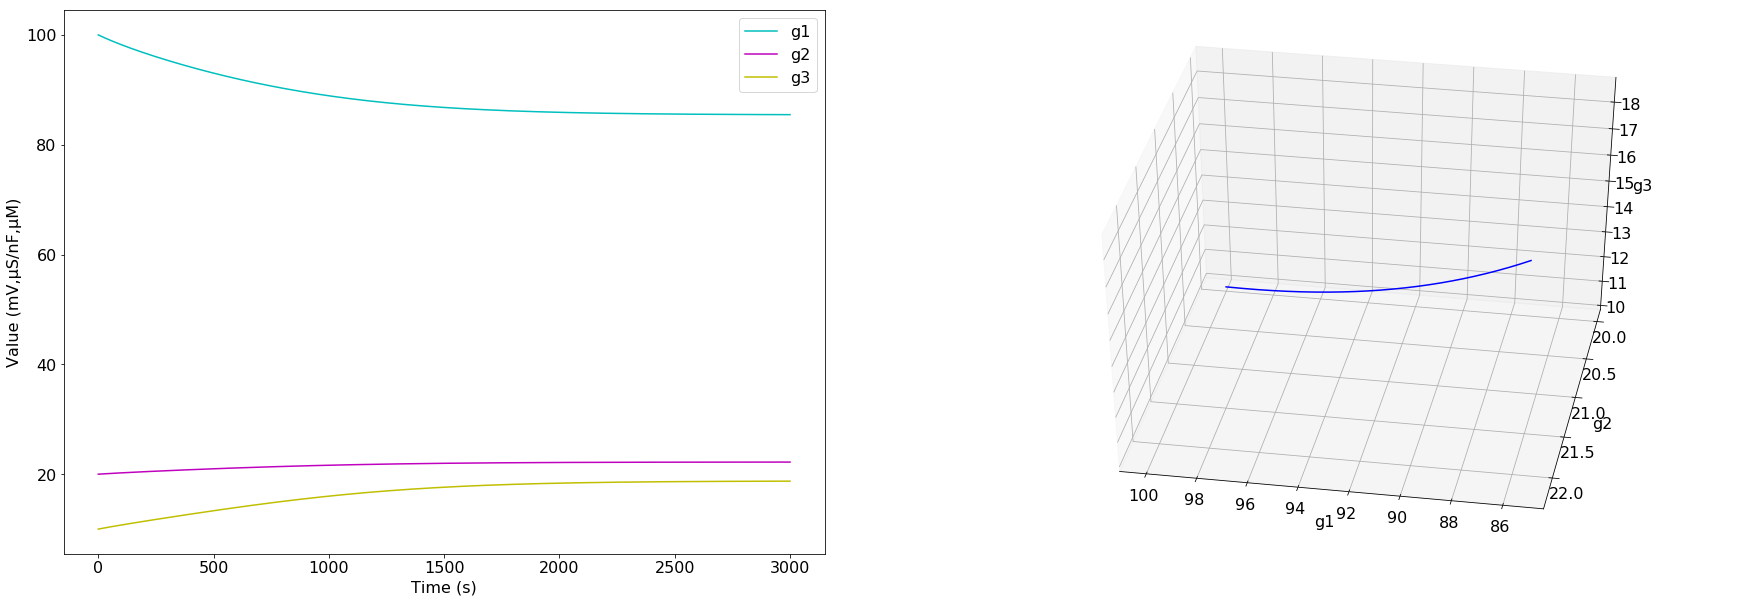

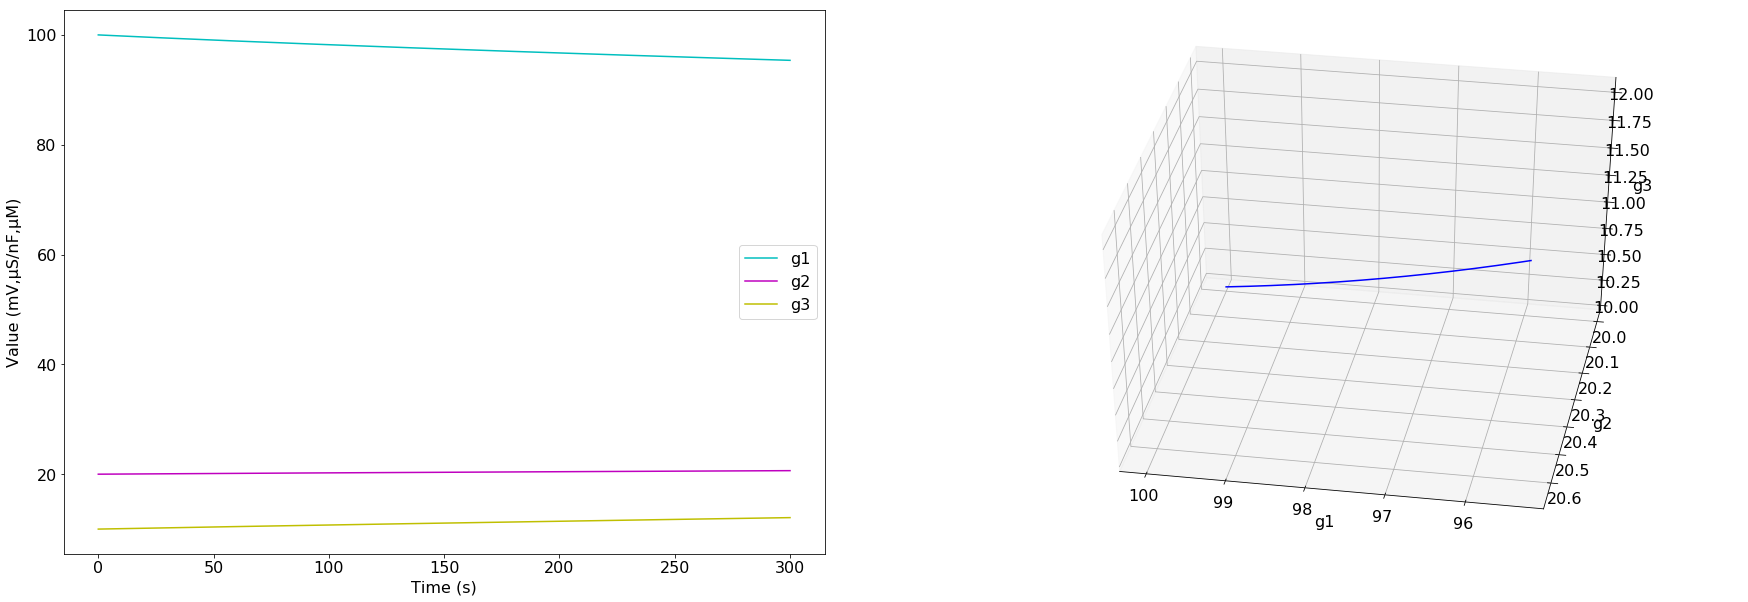

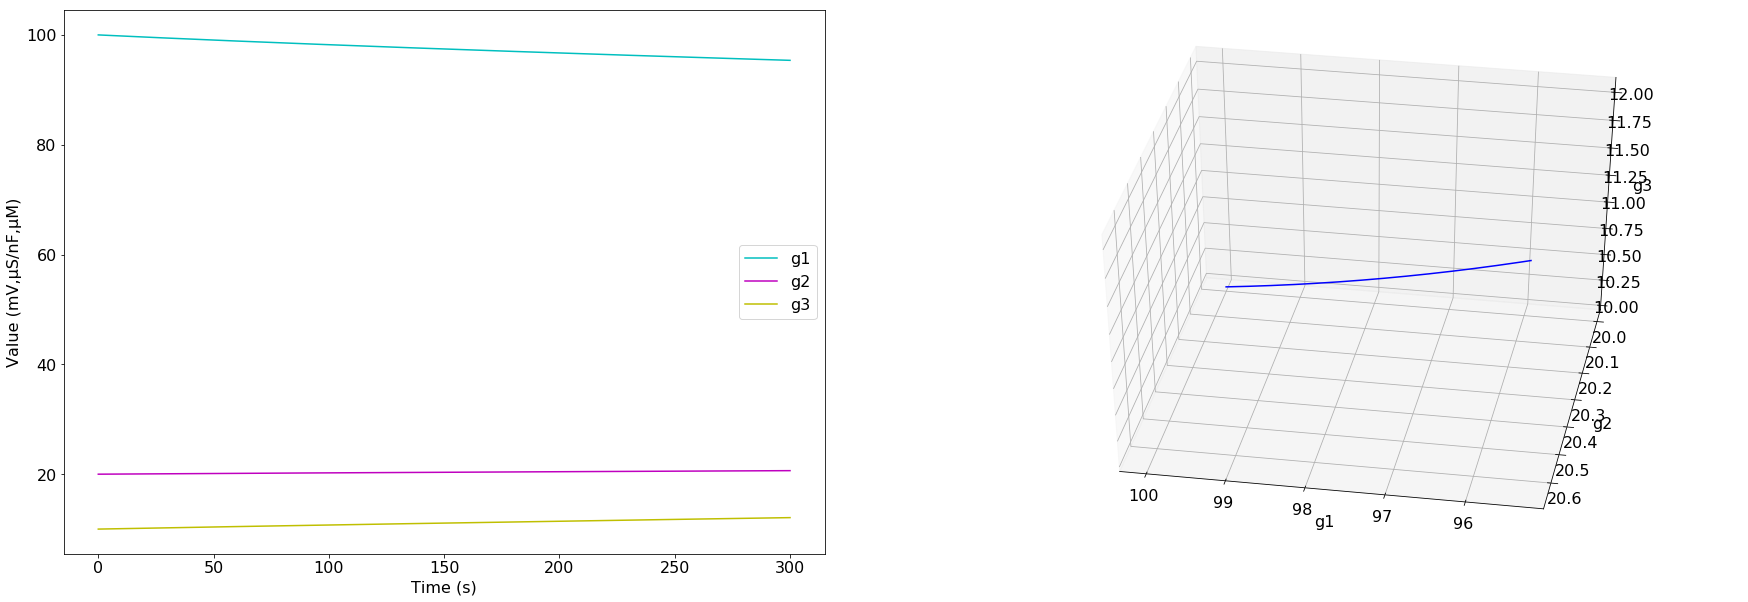

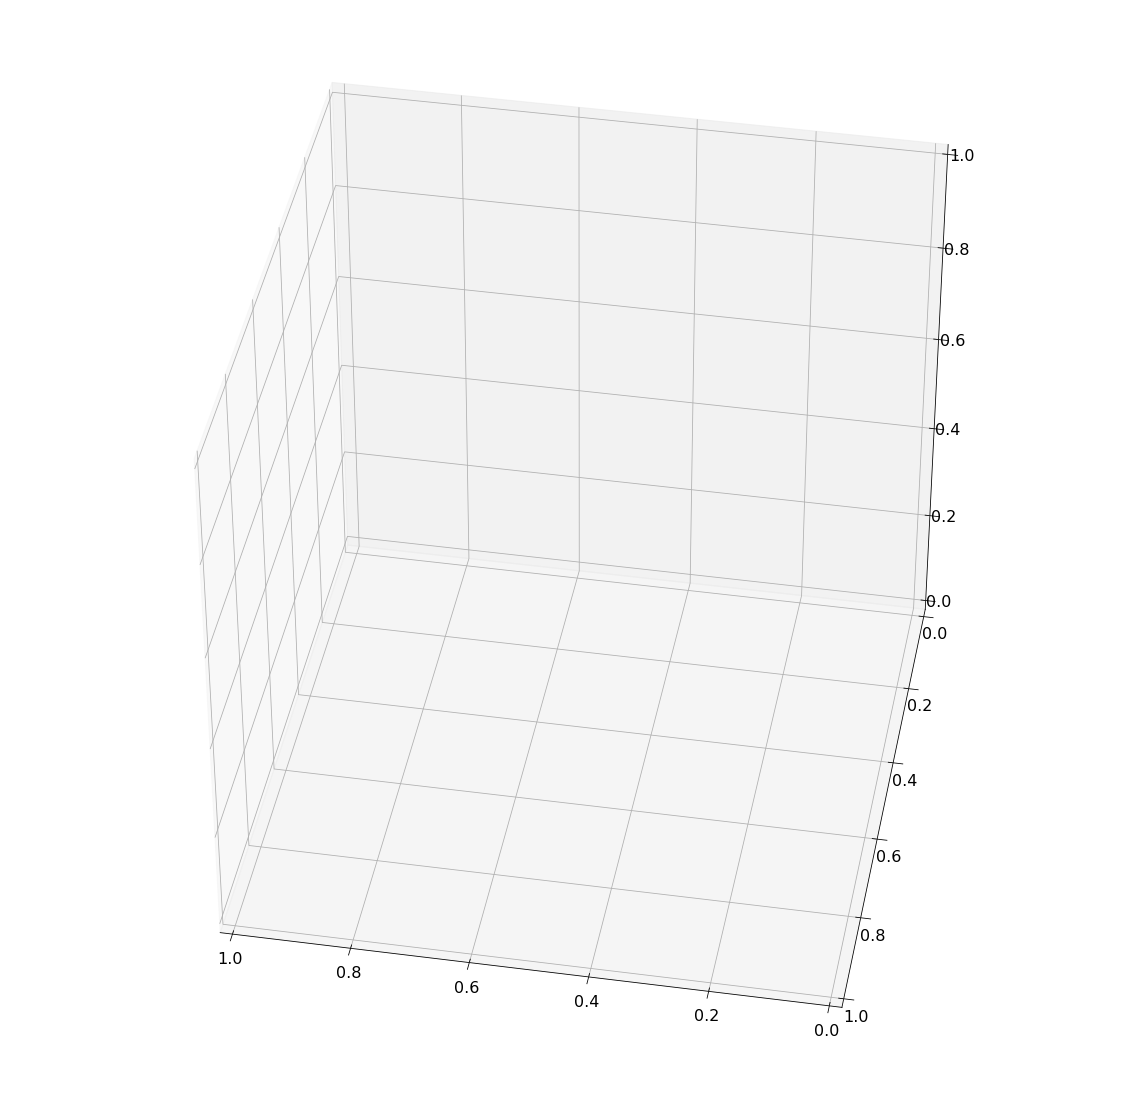

<Figure size 432x288 with 0 Axes>

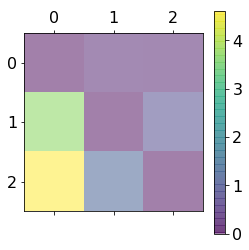

[[0.         0.21466476 0.23057623]
 [4.65842652 0.         1.07412241]
 [4.33696054 0.93099258 0.        ]]


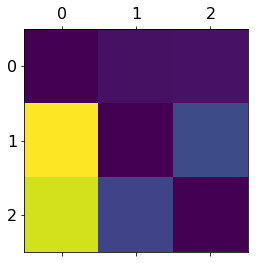

[[0.         0.2110269  0.23269923]
 [4.73873228 0.         1.10269933]
 [4.2973929  0.90686552 0.        ]]


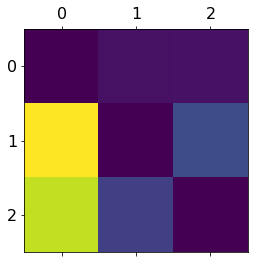

In [22]:
#many points, concentrated initial conditions in same area as paper
ogcorrsmall = pairwisecorr(originalModelsmallinit)[1]
fig = plt.figure(frameon=False)
print(ogcorrsmall)
mat1 = plt.matshow(ogcorrsmall,alpha=.5)
plt.colorbar()
plt.show()
flipcorrsmall = pairwisecorr(flippedModelsmallinit)[1]
print(flipcorrsmall)
plt.matshow(flipcorrsmall)
plt.show()
scalecorrsmall = pairwisecorr(scaledModelsmallinit)[1]
print(scalecorrsmall)
plt.matshow(scalecorrsmall)
plt.show()

In [23]:
#many points, spread out initial conditions
pairwisecorr(originalModel,plotting=True)


NameError: name 'originalModel' is not defined

In [21]:
print(pairwisecorr(originalModel)[1])
print(pairwisecorr(flippedModel)[1])
print(pairwisecorr(scaledModel)[1])

[[ 0.         -0.8248111   0.51649213]
 [-0.31518802  0.         -0.36126418]
 [ 1.27195919 -2.32819396  0.        ]]
[[ 0.         -0.51504463  0.43613141]
 [-0.4087793   0.         -0.39210391]
 [ 1.6571547  -1.87716668  0.        ]]
[[ 0.         -1.1659881   0.59593423]
 [-0.08052714  0.         -0.28700988]
 [ 0.46994888 -3.27718532  0.        ]]


*Future questions to ask:*
*   Time-series level:

> * Oscillations in green???
*   Are there initial conditions (especially in the flipped/anti-homeostatic case) where a steady state is not reached (or all conductances go to zero)? I expect this to be the case when more initial conditions are considered

*   Parameter space level:

> * Noise in the system-> stable results? (Glazier's suggestion)
*What are the trajectories through parameter space? (Glazier's suggestion)
*Map basin of attraction of $Ca^{2+}$ steady state
*Fitness landscape (where actually is the desired Ca concentration found?)

*  Tau level:

> * Identify sets of taus that do and do not converge (as they observed in the article)

